<a href="https://colab.research.google.com/github/flaviorv/ai_model_lifecycle/blob/tp2/linear_regression_tp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Feature select, train and validation

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KernelDensity
import pandas as pd
import numpy as np

breast_cancer = load_breast_cancer()

df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)

#Synthetic data
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(df)
samples = kde.sample(n_samples=500, random_state=42)
samples = pd.DataFrame(samples, columns=breast_cancer.feature_names)
df = pd.concat([samples, df], ignore_index=True)

#Target and features
y = df.pop('mean area')
x = df

#Split train, validation and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.8, random_state=42)
#Scaling features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)
#Adding noise
np.random.seed(42)
noise = np.random.normal(loc=0, scale=0.5, size=x_train.shape)
x_train = np.vstack([x_train, x_train + noise])
y_train = np.hstack([y_train, y_train])

#Filter feature selection with many k numbers to find the best combination
result = {}
print('Cross Validation')
for f in range(5, 26, 5):
  skb = SelectKBest(f_regression, k=f)
  selected_train = skb.fit_transform(x_train, y_train)
  selected_val = skb.transform(x_val)
  selected_test = skb.transform(x_test)
  lr = LinearRegression()
  train_score = cross_val_score(lr, selected_train, y_train, cv=3, scoring='r2')
  print(f'Train - Features {f:>10}',  f'R² {train_score.mean():<4.2f}')
  val_score = cross_val_score(lr, selected_val, y_val, cv=3, scoring='r2')
  print(f'Val - Features {f:>10}',  f'R² {val_score.mean():<4.2f}')
  test_score = cross_val_score(lr, selected_test, y_test, cv=3, scoring='r2')
  print(f'Test - Features {f:10}',  f'R² {test_score.mean():<4.2f}', '\n')
  result[f] = skb.get_support(indices=True)

Cross Validation
Train - Features          5 R² 0.90
Val - Features          5 R² 0.99
Test - Features          5 R² 0.99 

Train - Features         10 R² 0.90
Val - Features         10 R² 0.99
Test - Features         10 R² 0.99 

Train - Features         15 R² 0.89
Val - Features         15 R² 0.99
Test - Features         15 R² 0.99 

Train - Features         20 R² 0.90
Val - Features         20 R² 0.99
Test - Features         20 R² 0.99 

Train - Features         25 R² 0.89
Val - Features         25 R² 0.99
Test - Features         25 R² 0.99 



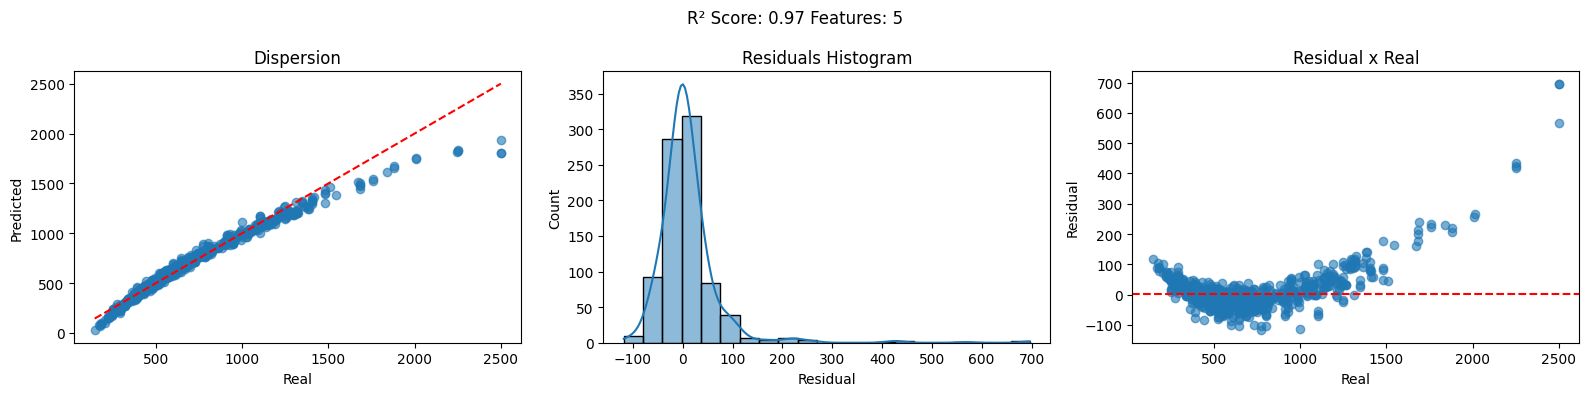

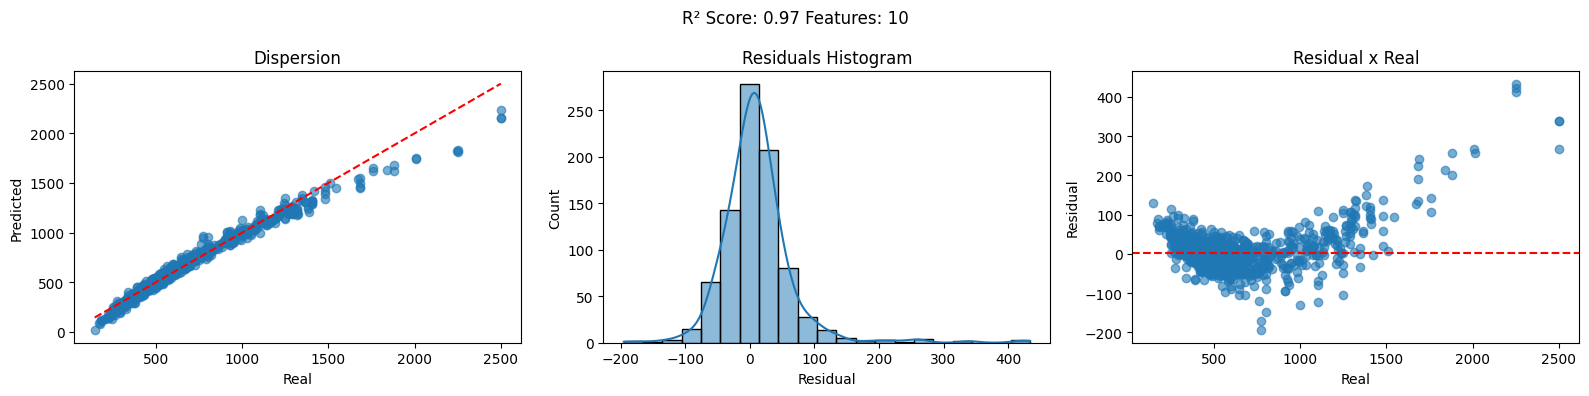

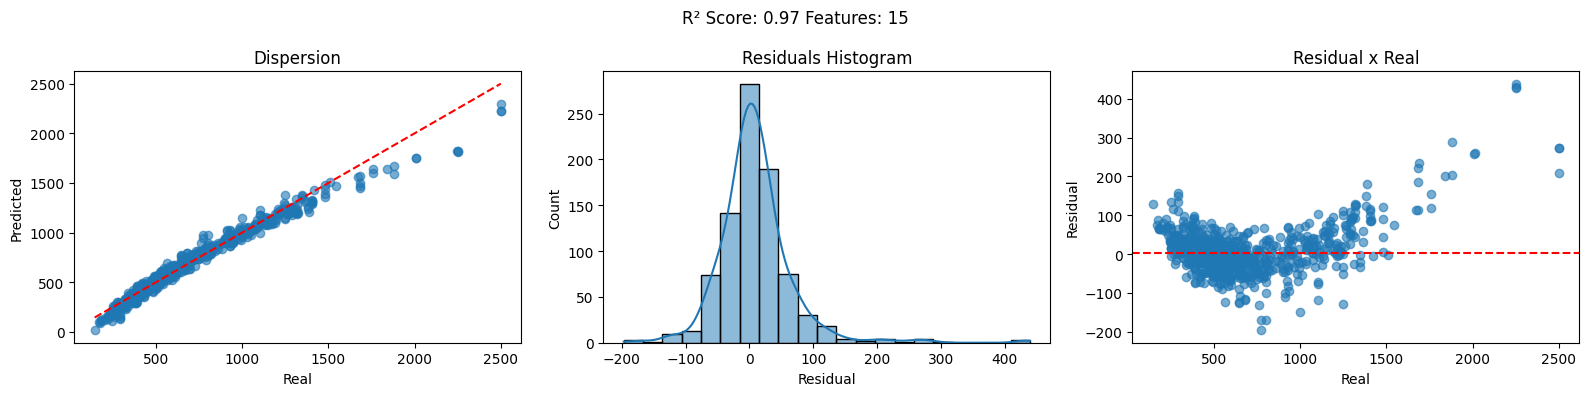

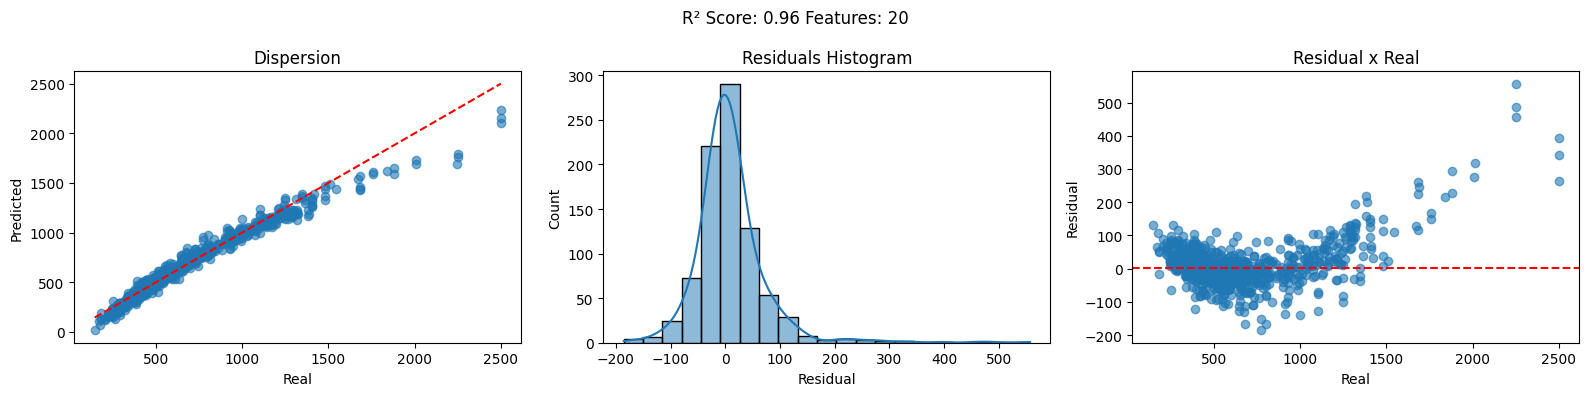

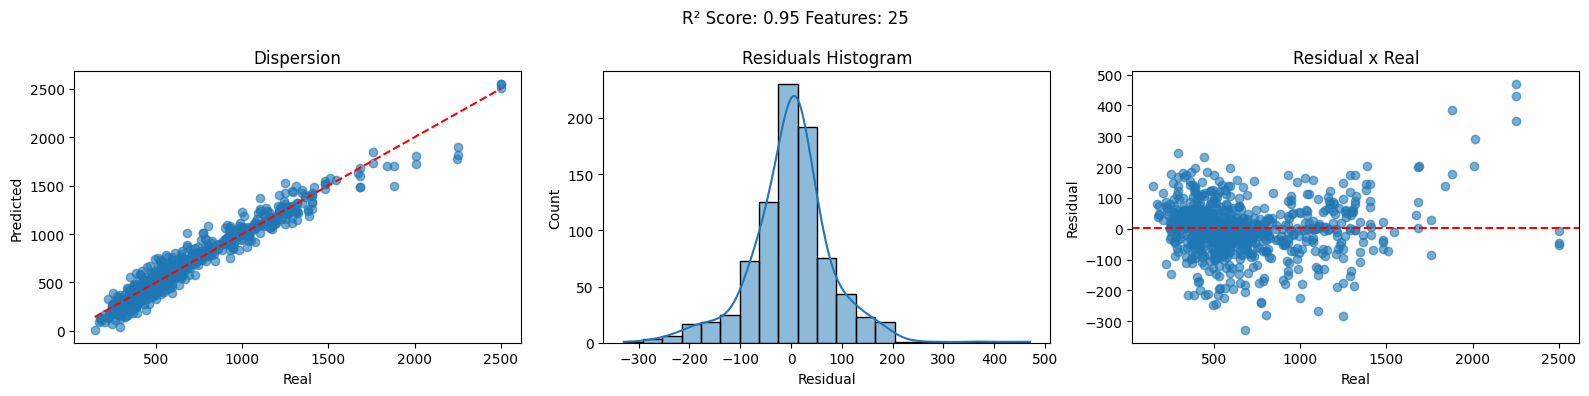

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

#Predicting with linear regression and different feature numbers
for nf in result:
  lr = LinearRegression()
  lr.fit(x_train[:, result[nf]], y_train)
  y_pred = lr.predict(x_test[:, result[nf]])

  fig, axes = plt.subplots(1, 3, figsize=(16, 4))
  axes[0].scatter(x=y_test, y=y_pred, alpha=0.6)
  axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
  axes[0].set_xlabel("Real")
  axes[0].set_ylabel("Predicted")
  axes[0].set_title(f"Dispersion")

  residuals = y_test - y_pred
  sns.histplot(residuals, bins=21, kde=True, ax=axes[1])
  axes[1].set_xlabel("Residual")
  axes[1].set_title(f"Residuals Histogram")

  axes[2].scatter(x=y_test, y=residuals, alpha=0.6)
  axes[2].axhline(y=2, color='r', linestyle='--')
  axes[2].set_xlabel("Real")
  axes[2].set_ylabel("Residual")
  axes[2].set_title("Residual x Real")

  plt.suptitle(f"R² Score: {r2_score(y_test, y_pred):.2f} Features: {nf}")
  plt.tight_layout()
  plt.show()